## Model with boundaries, volumes, and diffusion rates to try and find bistability
#### nicole pagane, april 2018

In [201]:
# import modules
%reset
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as snt
from decimal import Decimal
from matplotlib.colors import LogNorm

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [244]:
# define constants and model

## MODEL
###############################
#  ec  # m #  ic  # m #  ec  #
##############################
#  e1   1     c     2    e2
## VOLUMES (assuming reduced units)
# 100   10    50    10   100    
vol = [100, 10, 50, 10, 100]
Ve1 = vol[0]
V1 = vol[1]
Vc = vol[2]
V2 = vol[3]
Ve2 = vol[4]

## SPECIES
    # substrate to bind kinases on membrane (S) found in extracellular volumes
    # *cannot* diffuse through cell for now, may change eventually 
        #S(ec1)
        #S(ec2)
    # kinases (K) found in membranes and intracellular volumes
        #K(m1)
        #K(ic)
        #K(m2)
    # phosphoylated kinases (Kp) can diffuse into intracellular volume better than K
        #Kp(m1)
        #Kp(ic)
        #Kp(m2)
    # doubly phosphorylated kinases (Kpp) can diffuse into intracellular volume better than Kp
        #Kpp(m1)
        #Kpp(ic)
        #Kpp(m2)
# 10 species in all (by volume) with only 4 truly distinct species
initConc = np.ones(11)/np.asarray([vol[0], vol[4], vol[1], vol[2], vol[3], vol[1], vol[2], vol[3], vol[1], vol[2], vol[3]])
# mass balance laws:
    # Ktot = K + Kp + Kpp
        # K = K1 + Kc + K2
        # Kp = Kp1 + Kpc + Kp2
        # Kpp = Kpp1 + Kppc + Kpp2
    # Ktot = K1 + Kc + K2 + Kp1 + Kpc + Kp2 + Kpp1 + Kppc + Kpp2
Ktot = 1000
S1 = Ktot
S2 = 2*Ktot

## REACTIONS
    # left membrane
        # S1 + K1 -> Kp1                   k1
        # K1 + K1 -> Kp1 + Kp1             k2
        # Kp1 + K1 -> K1 + K1              k3
        # Kp1 + Kp1 -> Kpp1 + Kp1          k4
        # Kpp1 + Kp1 -> Kp1 + Kp1          k5
    # right membrane
        # S2 + K2 -> Kp2                   k1
        # K2 + K2 -> Kp2 + Kp2             k2
        # Kp2 + K2 -> K2 + K2              k3
        # Kp2 + Kp2 -> Kpp2 + Kp2          k4
        # Kpp2 + Kp2 -> Kp2 + Kp2          k5
    # subvolume transfers
        # K1 -> Kc       K reactions       k6/P1
        # Kc -> K1       .                 k6
        # K2 -> Kc       .                 k6/P1
        # Kc -> K2       .                 k6
        # Kp1 -> Kpc     Kp reactions      k6/P2
        # Kpc -> Kp1     .                 k6
        # Kp2 -> Kpc     .                 k6/P2
        # Kpc -> Kp2     .                 k6
        # Kpp1 -> Kppc   Kpp reactions     k6/P3
        # Kppc -> Kpp1   .                 k6
        # Kpp2 -> Kppc   .                 k6/P3
        # Kppc -> Kpp2   .                 k6
    # cellular reactions
        # Kc + Kc -> Kpc + Kc              k2
        # Kpc + Kc -> Kc + Kc              k3
        # Kpc + Kpc -> Kppc + Kpc          k4
        # Kppc + Kpc -> Kpc + Kpc          k5
    
## RATE CONSTANTS AND PARTITION COEFFICIENTS
adjFact = 1.0/Ktot
k1 = 50*adjFact/(max([S1,S2]))
k2 = 30*adjFact
k3 = 80*adjFact
k4 = 50*adjFact
k5 = 10*adjFact
k6 = 40*adjFact
P1 = 5
P2 = 3
P3 = 1

## CMEs
    # (left membrane species)
    # dCk1 = -k1*Cs1*Ck1*Ve1/V1 - k2*Ck1**2 + k3*Ckp1*Ck1 - k6/P1*Ck1 + k6*Ckc*Vc/V1
    # dCkp1 = k1*Cs1*Ck1*Ve1/V1 + k2*Ck1**2 - k3*Ckp1*Ck1 - k4*Ckp1**2 + k5*Ckpp1*Ckp1 - k6/P2*Ckp1 + k6*Ckpc*Vc/V1
    # dCkpp1 = k4*Ckp1**2 - k5*Ckp1*Ckpp1 - k6/P3*Ckpp1 + k6*Ckppc*Vc/V1
    # (right membrane species)
    # dCk2 = -k1*Cs2*Ck2*Ve2/V2 - k2*Ck2**2 + k3*Ckp2*Ck2 - k6/P1*Ck2 + k6*Ckc*Vc/V2
    # dCkp2 = k1*Cs2*Ck2*Ve2/V2 + k2*Ck2**2 - k3*Ckp2*Ck2 - k4*Ckp2**2 + k5*Ckpp2*Ckp2 - k6/P2*Ckp2 + k6*Ckpc*Vc/V2
    # dCkpp2 = k4*Ckp2**2 - k5*Ckp2*Ckpp2 - k6/P3*Ckpp2 + k6*Ckppc*Vc/V2
    # (intracellular species)
    # dCkc = k6/P1*(Ck1*V1 + Ck2*V2)/Vc  - 2*k6*Ckc - k2*Ckc**2 + k3*Ckc*Ckpc
    # dCkpc = k6/P2*(Ckp1*V1 + Ckp2*V2)/Vc - 2*k6*Ckpc + k2*Ckc**2 - k3*Ckc*Ckpc - k4*Ckpc**2 + k5*Ckppc*Ckpc
    # dCkppc = k6/P3*(Ckpp1*V1 + Ckpp2*V2)/Vc - 2*k6*Ckppc + k4*Ckpc**2 - k5*Ckppc*Ckpc

## REACTION MATRIX
#  S1*K1 K1 K1**2 K1*Kp1 Kp1 Kp1**2 Kp1*Kpp1 Kpp1 Kpp1**2 S2*K2 K2 K2**2 K2*Kp2 Kp2 Kp2**2 Kp2*Kpp2 Kpp2 Kpp2**2 Kc Kc**2  
#
#
#
#

In [245]:
n = 100
Kp = np.linspace(0, Ktot, n)
Kpp = np.linspace(0, Ktot, n)
diff = {}
diff['dCk1'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkp1'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkpp1'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCk2'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkp2'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkpp2'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkc'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkpc'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
diff['dCkppc'] = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
for i in range(len(Kp)):
    for j in range(len(Kpp)):
        K = Ktot - Kp[i] - Kpp[j]
        if K >= 0:
            Cs1, Cs2, Ck1, Ckc, Ck2, Ckp1, Ckpc, Ckp2, Ckpp1, Ckppc, Ckpp2 = initConc*np.asarray([S1, S2, 
                                                                            .4*K, .2*K, .4*K, # K1, Kc, K2
                                                                            .3*Kp[i], .4*Kp[i], .3*Kp[i],    # Kp1, Kpc, Kpc2
                                                                            Kpp[j]/3.0, Kpp[j]/3.0, Kpp[j]/3.0])# Kpp1, Kppc, Kpp2
            diff['dCk1'][i][j] = (-k1*Cs1*Ck1*Ve1/V1 - k2*Ck1**2 + k3*Ckp1*Ck1 - k6/P1*Ck1 + k6*Ckc*Vc/V1)**2
            diff['dCkp1'][i][j] = (k1*Cs1*Ck1*Ve1/V1 + k2*Ck1**2 - k3*Ckp1*Ck1 - k4*Ckp1**2 + k5*Ckpp1*Ckp1 - k6/P2*Ckp1 + k6*Ckpc*Vc/V1)**2
            diff['dCkpp1'][i][j] = (k4*Ckp1**2 - k5*Ckp1*Ckpp1 - k6/P3*Ckpp1 + k6*Ckppc*Vc/V1)**2
            diff['dCk2'][i][j] = (-k1*Cs2*Ck2*Ve2/V2 - k2*Ck2**2 + k3*Ckp2*Ck2 - k6/P1*Ck2 + k6*Ckc*Vc/V2)**2
            diff['dCkp2'][i][j] = (k1*Cs2*Ck2*Ve2/V2 + k2*Ck2**2 - k3*Ckp2*Ck2 - k4*Ckp2**2 + k5*Ckpp2*Ckp2 - k6/P2*Ckp2 + k6*Ckpc*Vc/V2)**2
            diff['dCkpp2'][i][j] = (k4*Ckp2**2 - k5*Ckp2*Ckpp2 - k6/P3*Ckpp2 + k6*Ckppc*Vc/V2)**2
            diff['dCkc'][i][j] = (k6/P1*(Ck1*V1 + Ck2*V2)/Vc  - 2*k6*Ckc - k2*Ckc**2 + k3*Ckc*Ckpc)**2
            diff['dCkpc'][i][j] = (k6/P2*(Ckp1*V1 + Ckp2*V2)/Vc - 2*k6*Ckpc + k2*Ckc**2 - k3*Ckc*Ckpc - k4*Ckpc**2 + k5*Ckppc*Ckpc)**2
            diff['dCkppc'][i][j] = (k6/P3*(Ckpp1*V1 + Ckpp2*V2)/Vc - 2*k6*Ckppc + k4*Ckpc**2 - k5*Ckppc*Ckpc)**2

/Users/nicolepagane/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


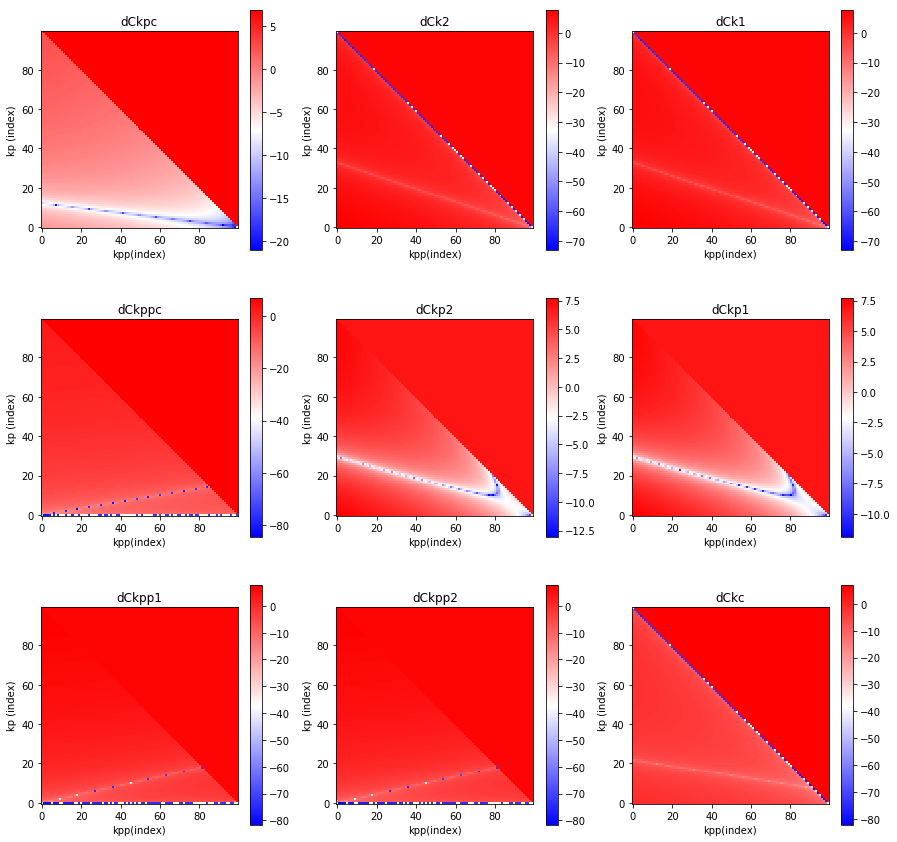

In [246]:
#plot all kinetic species
fig = plt.figure(figsize=(15,15))

ind = 1
for i in diff.keys():
    ax = fig.add_subplot(3,3,ind)
    plt.imshow(np.log(diff[i]), cmap = 'bwr', origin = 'lower')
    plt.xlabel('kpp(index)')
    plt.ylabel('kp (index)')
    plt.title(i)
    plt.colorbar()
    ind = ind +1

plt.show()

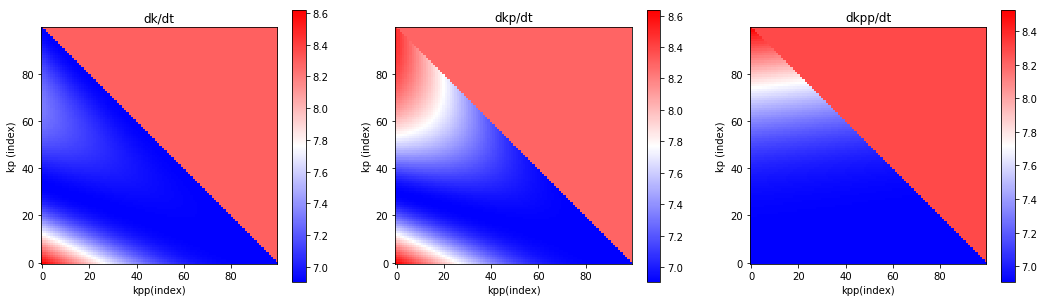

In [247]:
#plot all nondistinct species (not separtated by subvolume)
fig = plt.figure(figsize=(18,5))

dK = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
dKp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
dKpp = np.ones(len(Kp)*len(Kpp)).reshape([len(Kpp), len(Kp)])*1000
for i in diff.keys():
    if i == 'dCk1' or i == 'dCk2' or i == 'dCkc':
        dK = dK + diff[i]
    elif i == 'dCkp1' or i == 'dCkp2' or i == 'dCkpc':
        dKp = dKp + diff[i]
    else:
        dKpp = dKpp + diff[i]
    
    
    
ax = fig.add_subplot(1,3,1)
plt.imshow(np.log(dK), cmap = 'bwr', origin = 'lower')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dk/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,2)
plt.imshow(np.log(dKp), cmap = 'bwr', origin = 'lower')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dkp/dt')
plt.colorbar()
ax = fig.add_subplot(1,3,3)
plt.imshow(np.log(dKpp), cmap = 'bwr', origin = 'lower')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dkpp/dt')
plt.colorbar()

plt.show()

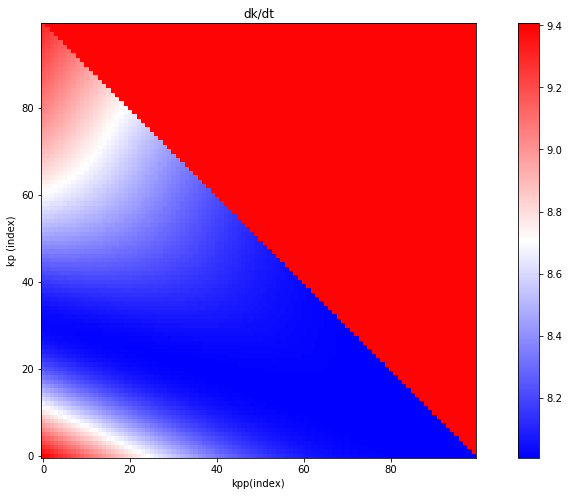

In [248]:
#plot total gradient
fig = plt.figure(figsize=(15,8))
plt.imshow(np.log(dK+dKp+dKpp), cmap = 'bwr', origin = 'lower')
plt.xlabel('kpp(index)')
plt.ylabel('kp (index)')
plt.title('dk/dt')
plt.colorbar()
plt.show()

In [220]:
grad = dK + dKp + dKpp
tol = Ktot
mins = []
inds = []
for i in range(np.shape(grad)[0]):
    for j in range(np.shape(grad)[1]):
        if grad[i,j] < tol:
            mins.append(grad[i,j])
            inds.append([i,j])
                
mins = np.asarray(mins)
print len(inds), 'combination found under', tol, 'tolerance'
for i in range(len(inds)):
    print Ktot - Kp[inds[i][0]] - Kpp[inds[i][1]], Kp[inds[i][0]], Kpp[inds[i][1]]

0 combination found under 1000 tolerance


In [134]:
# define kinetic rate laws to set up ode
# y 0 1 2  3  4  5  6   7   8
#   1 c 2 p1 pc p2 pp1 ppc pp2
def rates(y, t):
    return np.asarray([-k1*Cs1*y[0]*Ve1/V1 - k2*y[0]**2 + k3*y[3]*y[0] - k6/P1*y[0] + k6*y[1]*Vc/V1,
        k1*Cs1*y[0]*Ve1/V1 + k2*y[0]**2 - k3*y[3]*y[0] - k4*y[3]**2 + k5*y[6]*y[3] - k6/P2*y[3] + k6*y[4]*Vc/V1,
        k4*y[3]**2 - k5*y[3]*y[6] - k6/P3*y[6] + k6*y[7]*Vc/V1,
        -k1*Cs2*y[2]*Ve2/V2 - k2*y[2]**2 + k3*y[5]*y[2] - k6/P1*y[2] + k6*y[1]*Vc/V2,
        k1*Cs2*y[2]*Ve2/V2 + k2*y[2]**2 - k3*y[5]*y[2] - k4*y[5]**2 + k5*y[8]*y[5] - k6/P2*y[5] + k6*y[4]*Vc/V2,
        k4*y[5]**2 - k5*y[5]*y[8] - k6/P3*y[8] + k6*y[7]*Vc/V2,
        k6/P1*(y[0]*V1 + y[2]*V2)/Vc  - 2*k6*y[1] - k2*y[1]**2 + k3*y[1]*y[4],
        k6/P2*(y[3]*V1 + y[5]*V2)/Vc - 2*k6*y[4] + k2*y[1]**2 - k3*y[1]*y[4] - k4*y[4]**2 + k5*y[7]*y[4],
        k6/P3*(y[6]*V1 + y[8]*V2)/Vc - 2*k6*y[7] + k4*y[4]**2 - k5*y[7]*y[4]])